In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
os.environ["KMP_DUPLICSCORE_LIB_OK"]="TRUE"

In [17]:
cocycles_results = torch.load("Csuite_Cocycles_trials=20_scheduler=False_decay=0_CV.pt")
scm_results = torch.load("Csuite_SCM_results_trials=20_scheduler=False_decay=0_CV.pt")

In [18]:
# Getting unique names
names = []
for result in cocycles_results+scm_results:
    if result['names'] not in names:
        names.append(result['names'])
print(names)

['Cocycles_CMMD_U', 'Cocycles_CMMD_V', 'Cocycles_LS', 'G-RQS SCM', 'L-RQS SCM', 'TA-RQS SCM']


In [19]:
# Getting unique datasets and dists 
dists = []
datasets = []
for result in scm_results:
    if str(result['base dist']) not in dists:
        dists.append( str(result['base dist']))
    if result['dataset'] not in datasets:
        datasets.append(result['dataset'])
print(dists,datasets)

['Normal(loc: 0.0, scale: 1.0)', 'Bernoulli(probs: 0.5)', 'Gamma(concentration: 1.0, rate: 1.0)'] ['Fork', 'Simpson', 'NonlinG']


In [20]:
MMD = torch.zeros((len(datasets),len(dists),len(names),5,50))
ATE = torch.zeros((len(datasets),len(dists),len(names),5,50))
KSD = torch.zeros((len(datasets),len(dists),len(names),5,50))
results_counter = torch.zeros(len(datasets),len(dists),len(names)).int()
for result in cocycles_results+scm_results:
    dataset_index = datasets.index(result['dataset'])
    dist_index = dists.index(str(result['base dist']))
    name_index = names.index(result['names'])
    MMD[dataset_index,dist_index,name_index,:,results_counter[dataset_index,dist_index,name_index]] = result['MMD']
    ATE[dataset_index,dist_index,name_index,:,results_counter[dataset_index,dist_index,name_index]] = result['ATE']
    KSD[dataset_index,dist_index,name_index,:,results_counter[dataset_index,dist_index,name_index]] = result['KSD']
    results_counter[dataset_index,dist_index,name_index]+=1
    

In [37]:
Table_MMD = torch.zeros((len(datasets),len(names),len(dists)))
Table_KSD = torch.zeros((len(datasets),len(names),len(dists)))
Table_ATE = torch.zeros((len(datasets),len(names),len(dists)))
int_inds = [[0,1,2],
            [2],
            [2,3,4]]
for i in range(len(datasets)):
    for d in range(len(dists)):
        Table_MMD[i,:,d] = MMD[i,d,:,int_inds[i]].mean((1,2))
        Table_ATE[i,:,d] = ATE[i,d,:,int_inds[i]].abs().mean((1,2))
        Table_KSD[i,:,d] = KSD[i,d,:,int_inds[i]].abs().mean((1,2))

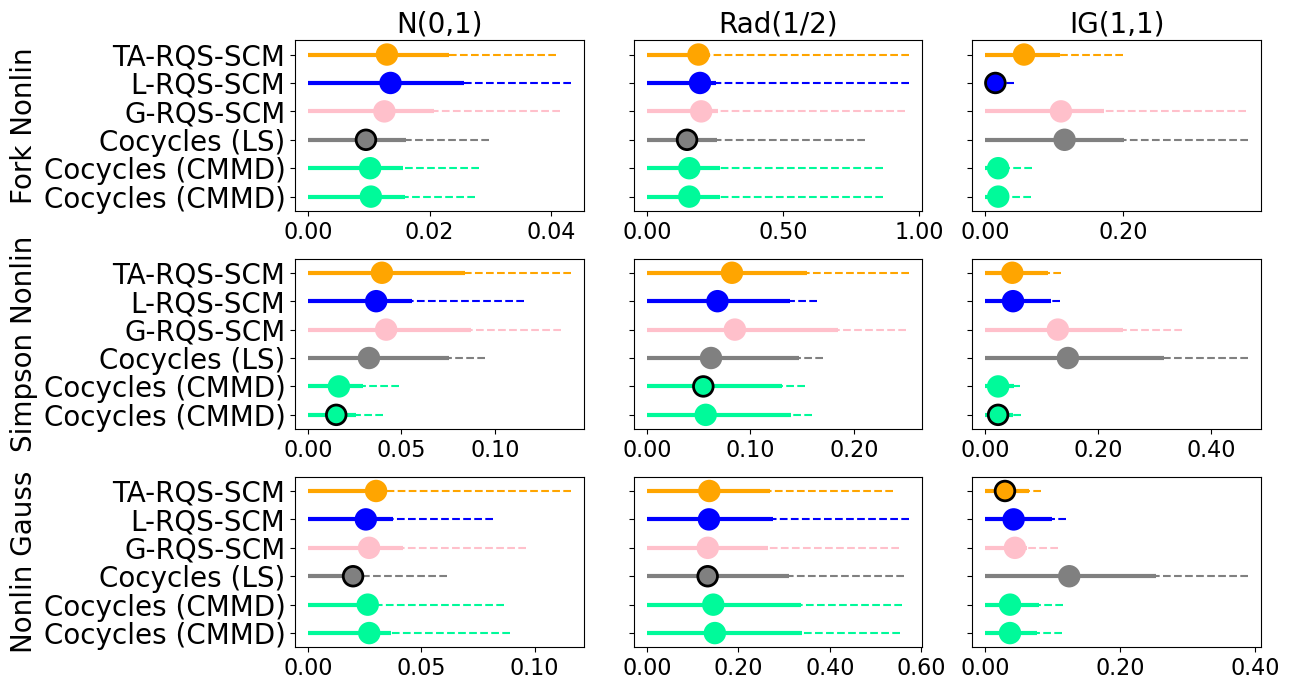

In [38]:
"""
Scatter plot
"""

# constructing results 
names = ['Cocycles (CMMD)', 'Cocycles (CMMD)', 'Cocycles (LS)', 'G-RQS-SCM', 'L-RQS-SCM', 'TA-RQS-SCM']
#names = ['G-RQS-SCM', 'L-RQS-SCM', 'TA-RQS-SCM']
score = "Mean"
results_names = ["Simpson","Fork","nonling"]
s = (score != "MMD")


Dataset_names = ["Fork Nonlin", "Simpson Nonlin", "Nonlin Gauss"]
#Dist_names = ["N(0,1)",r"IG(3,2)",r"IG(2,$\sqrt{2}$)",r"IG(1,1)"]
Dist_names = ["N(0,1)",r"Rad(1/2)",r"IG(1,1)"]
Colours = [["brown","navy","purple","orange","blue","pink",
            "grey","mediumspringgreen","mediumspringgreen"][::-1] for i in range(3)]
model_select = [0,1,2,3,4,5]
Model_names = []
colours = [[],[],[]]
for i in model_select:
    Model_names.append(names[i])
    for j in range(len(Colours)):
        colours[j].append(Colours[j][i]) 

inds = [i+1 for i in range(len(model_select))]
colours_best = colours

quantiles = [0.75,0.9,0.9]
linestyles = ["-", "--","--"]
lws = [3,1.5,1.5]

# Creating plots of results
from matplotlib import rcParams, rc_file_defaults
from matplotlib.ticker import FormatStrFormatter

ylabelsize = 20
xlabelsize = 16
rc_file_defaults()
rcParams['xtick.labelsize'] = xlabelsize
rcParams['ytick.labelsize'] = ylabelsize 

fig,axs = plt.subplots(nrows=3, ncols = 3, figsize = (13,7))
for i in range(3):
    for k in range(3):
        axs[i,k].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[i,k].set_yticks(inds[::-1])
        axs[i,k].set_ylim(0.5,len(inds)+0.5)
        means = MMD[i,k,model_select][:,int_inds[i]].mean((1,2))
        sd = MMD[i,k,model_select][:,int_inds[i]].var((1,2))**0.5
        if k == 0:
            axs[i,k].set_yticklabels(np.array(Model_names)[::-1])
            axs[i,k].set_ylabel(Dataset_names[i], fontsize = 20)
        else:
            axs[i,k].set_yticklabels([""]*len(Model_names))
        if i ==0:
            axs[i,k].set_title(Dist_names[k], fontsize = 20)
        
        cols_best = copy.deepcopy(colours_best[i])
        sorted_means = means.sort()[0]
        best_two = [torch.where(sorted_means[i] == means)[0][0] for i in range(1)]
        for c in range(len(best_two)):
            cols_best[best_two[c]]= "black"
        axs[i,k].scatter(means,inds, color = colours[i], s = 200, label = "median",zorder = 12,edgecolors=cols_best, lw=2)
        for j in range(2):
            upper = np.quantile(MMD[i,k,model_select][:,int_inds[i]],quantiles[j],(1,2))
            lower = np.quantile(MMD[i,k,model_select][:,int_inds[i]],1-quantiles[j],(1,2))
            axs[i,k].hlines(inds, upper, lower, color=colours[j], linestyle=linestyles[j], lw=lws[j], 
                          label = "{0}th - {1}th percentiles".format(int(100-quantiles[j]*100), int(quantiles[j]*100)),
                        zorder = 10-3*j)

#plt.legend(fontsize = 16, loc = (-0.27,-0.5), ncol = 1)
fig.tight_layout() 
fig.savefig("Csuite_experiments_box_scatter_plot_RQS{0}".format(str(score)))
plt.show()

IndexError: index 6 is out of bounds for dimension 0 with size 6

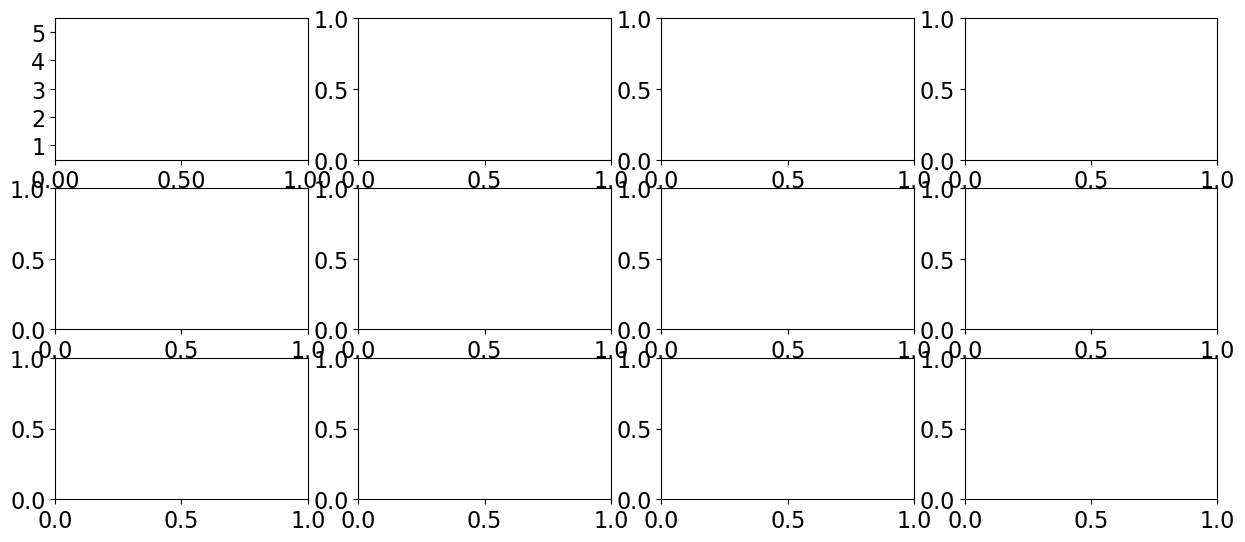

In [26]:
"""
Scatter plot
"""

# constructing results 
score = "ATE"
results_names = ["Simpson","Fork","nonling"]
s = (score != "MMD")


names = ['Cocycles (CMMD)', 'Cocycles (CMMD)', 'Cocycles (LS)', 'G-SCM', 'L-SCM', 'TA-SCM', 'RQS-SCM', 'L-RQS-SCM', 'TA-RQS-SCM']

Dataset_names = ["Fork Nonlin", "Simpson Nonlin", "Nonlin Gauss"]
Dist_names = ["N(0,1)",r"IG(3,2)",r"IG(2,$\sqrt{2}$)",r"IG(1,1)"]
Colours = [["brown","purple","navy","pink","brown","orange",
            "grey","mediumspringgreen","mediumspringgreen"][::-1] for i in range(3)]
model_select = [0,2,6,4,3]
Model_names = []
colours = [[],[],[]]
for i in model_select:
    Model_names.append(names[i])
    for j in range(len(Colours)):
        colours[j].append(Colours[j][i]) 

inds = [i+1 for i in range(len(model_select))]
colours_best = colours

quantiles = [0.75,0.9,0.9]
linestyles = ["-", "--","--"]
lws = [3,1.5,1.5]

# Creating plots of results
from matplotlib import rcParams, rc_file_defaults
from matplotlib.ticker import FormatStrFormatter

ylabelsize = 16
xlabelsize = 16
rc_file_defaults()
rcParams['xtick.labelsize'] = xlabelsize
rcParams['ytick.labelsize'] = ylabelsize 

fig,axs = plt.subplots(nrows=3, ncols = 4, figsize = (15,6.25))
for i in range(3):
    for k in range(4):
        axs[i,k].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[i,k].set_yticks(inds)
        axs[i,k].set_ylim(0.5,len(inds)+0.5)
        means = torch.flip(MMD[i,k,model_select][:,int_inds[i]].mean((1,2)),(0,))
        sd = MMD[i,k,model_select][:,int_inds[i]].var((1,2))**0.5
        if k == 0:
            axs[i,k].set_yticklabels(np.array(Model_names)[::-1])
            axs[i,k].set_ylabel(Dataset_names[i], fontsize = 18)
        else:
            axs[i,k].set_yticklabels([""]*len(Model_names))
        if i ==0:
            axs[i,k].set_title(Dist_names[k], fontsize = 20)
        
        cols_best = copy.deepcopy(colours_best[i][::-1])
        sorted_means = means.sort()[0]
        best_two = [torch.where(sorted_means[i] == means)[0][0] for i in range(1)]
        for c in range(len(best_two)):
            cols_best[best_two[c]]= "black"        
        axs[i,k].scatter(means,inds, color = colours[i][::-1], s = 175, label = "median",zorder = 12,edgecolors=cols_best, lw=2)
        axs[i,k].vlines(0.1,0,10, color= "grey", linestyle = "dashed")
        #axs[i,k].set_xlim(0,0.2)
        for j in range(2):
            upper = np.quantile(torch.flip(MMD[i,k,model_select][:,int_inds[i]],(0,)),quantiles[j],(1,2))
            lower = np.quantile(torch.flip(MMD[i,k,model_select][:,int_inds[i]],(0,)),1-quantiles[j],(1,2))
            axs[i,k].hlines(inds, upper, lower, color=colours[j][::-1], linestyle=linestyles[j], lw=lws[j], 
                          label = "{0}th - {1}th percentiles".format(int(100-quantiles[j]*100), int(quantiles[j]*100)),
                        zorder = 10-3*j)

#plt.legend(fontsize = 16, loc = (-0.27,-0.5), ncol = 1)
fig.tight_layout() 
fig.savefig("Csuite_experiments_box_scatter_plot_{0}".format(str(score)))
plt.show()